# Project task 02: Restaurant recommendation

In [1]:
import scipy.sparse as sp
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge
import time
import random, sys

In [2]:
import sys
sys.executable

'/anaconda3/envs/mmds_virtual/bin/python'

The goal of this task is to recommend restaurants to users based on the rating data in the Yelp dataset. For this, we try to predict the rating a user will give to a restaurant they have not been to yet based on a latent factor model.

## 1. Load data

First download `ratings.npy` from Piazza ([download link](https://syncandshare.lrz.de/dl/fiKMoxRNusLoFpFHkXXEgvdZ/ratings.npy)).

In [3]:
ratings = np.load("ratings.npy")

In [4]:
# We have triplets of (user, restaurant, rating).
ratings

array([[101968,   1880,      1],
       [101968,    284,      5],
       [101968,   1378,      2],
       ...,
       [ 72452,   2100,      4],
       [ 72452,   2050,      5],
       [ 74861,   3979,      5]], dtype=uint32)

Now we transform the data into a matrix of dimension [N, D], where N is the number of users and D is the number of restaurants in the dataset.  
We **strongly recommend** to load the data as a sparse matrix to avoid out-of-memory issues.

In [5]:
number_of_users = len(np.unique(ratings[:,0]))
number_of_restaurants = len(np.unique(ratings[:,1]))
M = sp.csr_matrix((ratings[:,2], (ratings[:,0], ratings[:,1])), 
                  shape=(number_of_users, number_of_restaurants))
M

<337867x5899 sparse matrix of type '<class 'numpy.uint32'>'
	with 929606 stored elements in Compressed Sparse Row format>

## 2. Preprocess the data

In the preprocessing step, we recursively remove all users and restaurants with 10 or less ratings. 

Then, we randomly select 200 data points for the validation and test sets, respectively.

After this, we subtract the mean rating for each users to account for this global effect.   
**Hint**: Some entries might become zero in this process -- but these entries are different than the 'unknown' zeros in the matrix. Store the indices of which we have data available in a separate variable.

In [6]:
def cold_start_preprocessing(matrix, min_entries):
    """
    Recursively removes rows and columns from the input matrix which have less than min_entries nonzero entries.
    
    Parameters
    ----------
    matrix      : sp.spmatrix, shape [N, D]
                  The input matrix to be preprocessed.
    min_entries : int
                  Minimum number of nonzero elements per row and column.

    Returns
    -------
    matrix      : sp.spmatrix, shape [N', D']
                  The pre-processed matrix, where N' <= N and D' <= D
        
    """
    print("Shape before: {}".format(matrix.shape))
    
    ### YOUR CODE HERE ###
    while True:
        shape = matrix.shape
        matrix = matrix[matrix.getnnz(1)>min_entries]
        matrix = matrix[:,matrix.getnnz(0)>min_entries]
        shape_new = matrix.shape
        if shape == shape_new:
            break
    print("Shape after: {}".format(matrix.shape))
    nnz = matrix>0
    assert (nnz.sum(0).A1 > min_entries).all()
    assert (nnz.sum(1).A1 > min_entries).all()
    return matrix

In [7]:
def shift_user_mean(matrix):
    """
    Subtract the mean rating per user from the non-zero elements in the input matrix.
    
    Parameters
    ----------
    matrix : sp.spmatrix, shape [N, D]
             Input sparse matrix.
    Returns
    -------
    matrix : sp.spmatrix, shape [N, D]
             The modified input matrix.
    
    user_means : np.array, shape [N, 1]
                 The mean rating per user that can be used to recover the absolute ratings from the mean-shifted ones.

    """
    
    ### YOUR CODE HERE ###
    tot = np.array(matrix.sum(axis=1).squeeze())[0]
    cts = np.diff(matrix.indptr)
    user_means = tot/cts
    d = sp.diags(user_means, 0)
    b = matrix.copy()
    b.data = np.ones_like(b.data)
    matrix = (matrix - d*b)   
    assert np.all(np.isclose(matrix.mean(1), 0))
    return matrix, user_means

In [8]:
def split_data(matrix, n_validation, n_test):
    """
    Extract validation and test entries from the input matrix. 
    
    Parameters
    ----------
    matrix          : sp.spmatrix, shape [N, D]
                      The input data matrix.
    n_validation    : int
                      The number of validation entries to extract.
    n_test          : int
                      The number of test entries to extract.

    Returns
    -------
    matrix_split    : sp.spmatrix, shape [N, D]
                      A copy of the input matrix in which the validation and test entries have been set to zero.
    
    val_idx         : tuple, shape [2, n_validation]
                      The indices of the validation entries.
    
    test_idx        : tuple, shape [2, n_test]
                      The indices of the test entries.
    
    val_values      : np.array, shape [n_validation, ]
                      The values of the input matrix at the validation indices.
                      
    test_values     : np.array, shape [n_test, ]
                      The values of the input matrix at the test indices.

    """
    
    ### YOUR CODE HERE ###
    indices = matrix.nonzero()
    a = np.arange(0, len(indices[0]), 1)
    np.random.shuffle(a)
    val_idx = ([],[])
    test_idx = ([],[])
    val_values = np.zeros(n_validation)
    test_values = np.zeros(n_test)
    matrix_split = matrix.copy()


    for i in range(n_validation):
            val_idx[0].append(indices[0][a[i]])
            val_idx[1].append(indices[1][a[i]])
            val_values[i] = matrix[indices[0][a[i]],indices[1][a[i]]]
            matrix_split[indices[0][a[i]],indices[1][a[i]]] = 0
            
            
    for i in range(n_test):
            test_idx[0].append(indices[0][a[i + n_validation]])
            test_idx[1].append(indices[1][a[i + n_validation]])
            test_values[i] = matrix[indices[0][a[i + n_validation]],indices[1][a[i + n_validation]]]
            matrix_split[indices[0][a[i + n_validation]],indices[1][a[i + n_validation]]] = 0
    
    matrix_split.eliminate_zeros()
    return matrix_split, val_idx, test_idx, val_values, test_values

In [9]:
M = cold_start_preprocessing(M, 10)

Shape before: (337867, 5899)
Shape after: (11275, 3531)


In [10]:
n_validation = 200
n_test = 200
# Split data
M_train, val_idx, test_idx, val_values, test_values = split_data(M, n_validation, n_test)

In [11]:
# Store away the nonzero indices of M before subtracting the row means.
nonzero_indices = M_train.nonzero()

# Remove user means.
M_shifted, user_means = shift_user_mean(M_train)

# Apply the same shift to the validation and test data.
val_values_shifted = val_values.copy()
test_values_shifted = test_values.copy()
for i in range(0, n_validation):
    val_values_shifted[i] = val_values_shifted[i] - user_means[val_idx[0][i]]
    test_values_shifted[i] = test_values_shifted[i] - user_means[test_idx[0][i]]


## 3. Alternating optimization

In the first step, we will approach the problem via alternating optimization, as learned in the lecture.

In [77]:
def initialize_Q_P(matrix, k, init='random'):
    """
    Initialize the matrices Q and P for a latent factor model.
    
    Parameters
    ----------
    matrix : sp.spmatrix, shape [N, D]
             The matrix to be factorized.
    k      : int
             The number of latent dimensions.
    init   : str in ['svd', 'random'], default: 'random'
             The initialization strategy. 'svd' means that we use SVD to initialize P and Q, 'random' means we initialize
             the entries in P and Q randomly in the interval [0, 1).

    Returns
    -------
    Q : np.array, shape [N, k]
        The initialized matrix Q of a latent factor model.

    P : np.array, shape [k, D]
        The initialized matrix P of a latent factor model.
    """

    
    if init == 'svd':
        U, sigma, P = svds(matrix, k)
        x = np.eye(k)
        sigma = x * sigma
        Q = np.matmul(U, sigma)
    elif init == 'random':
        Q = np.random.rand(matrix.shape[0], k)
        P = np.random.rand(k, matrix.shape[1])
    else:
        raise ValueError
        
    assert Q.shape == (matrix.shape[0], k)
    assert P.shape == (k, matrix.shape[1])
    return Q, P

In [71]:
Q, P = initialize_Q_P(M_shifted, 30, init='random')

In [127]:
def latent_factor_alternating_optimization(M, non_zero_idx, k, val_idx, val_values,
                                           reg_lambda, max_steps=100, init='random',
                                           log_every=1, patience=10, eval_every=1):
    """
    Perform matrix factorization using alternating optimization. Training is done via patience,
    i.e. we stop training after we observe no improvement on the validation loss for a certain
    amount of training steps. We then return the best values for Q and P oberved during training.
    
    Parameters
    ----------
    M                 : sp.spmatrix, shape [N, D]
                        The input matrix to be factorized.
                      
    non_zero_idx      : np.array, shape [nnz, 2]
                        The indices of the non-zero entries of the un-shifted matrix to be factorized. 
                        nnz refers to the number of non-zero entries. Note that this may be different
                        from the number of non-zero entries in the input matrix M, e.g. in the case
                        that all ratings by a user have the same value.
    
    k                 : int
                        The latent factor dimension.
    
    val_idx           : tuple, shape [2, n_validation]
                        Tuple of the validation set indices.
                        n_validation refers to the size of the validation set.
                      
    val_values        : np.array, shape [n_validation, ]
                        The values in the validation set.
                      
    reg_lambda        : float
                        The regularization strength.
                      
    max_steps         : int, optional, default: 100
                        Maximum number of training steps. Note that we will stop early if we observe
                        no improvement on the validation error for a specified number of steps
                        (see "patience" for details).
                      
    init              : str in ['random', 'svd'], default 'random'
                        The initialization strategy for P and Q. See function initialize_Q_P for details.
    
    log_every         : int, optional, default: 1
                        Log the training status every X iterations.
                    
    patience          : int, optional, default: 10
                        Stop training after we observe no improvement of the validation loss for X evaluation
                        iterations (see eval_every for details). After we stop training, we restore the best 
                        observed values for Q and P (based on the validation loss) and return them.
                      
    eval_every        : int, optional, default: 1
                        Evaluate the training and validation loss every X steps. If we observe no improvement
                        of the validation error, we decrease our patience by 1, else we reset it to *patience*.

    Returns
    -------
    best_Q            : np.array, shape [N, k]
                        Best value for Q (based on validation loss) observed during training
                      
    best_P            : np.array, shape [k, D]
                        Best value for P (based on validation loss) observed during training
                      
    validation_losses : list of floats
                        Validation loss for every evaluation iteration, can be used for plotting the validation
                        loss over time.
                        
    train_losses      : list of floats
                        Training loss for every evaluation iteration, can be used for plotting the training
                        loss over time.                     
    
    converged_after   : int
                        it - patience*eval_every, where it is the iteration in which patience hits 0,
                        or -1 if we hit max_steps before converging. 

    """

    ### YOUR CODE HERE ###
    
    temp_patience = patience
    initial_val_loss = 1000000
    train_losses = []
    validation_losses = []
    time_list = []
    Q, P = initialize_Q_P(matrix = M, k = k, init = init)
    for step in range(max_steps):
        start_time = time.clock()
        i = non_zero_idx[0]
        j = non_zero_idx[1]
        num_user = M.shape[0]
        num_items = M.shape[1]
        if step % eval_every == 0:
            
            # calculate the training loss
            train_loss = 0
            validation_loss = 0
            i = non_zero_idx[0]
            j = non_zero_idx[1]
            train_loss = np.sum(np.square(M[i,j] - np.matmul(Q,P)[i,j]))
            
            # calculate the validation loss
            for count in range(len(val_values)):
                i = val_idx[0][count]
                j = val_idx[1][count]
                validation_loss += pow(val_values[count] - np.dot(Q[i,:], P[:,j]), 2)    
            if validation_loss < initial_val_loss:
                best_Q = Q.copy()
                best_P = P.copy()
                initial_val_loss = validation_loss
                temp_patience = patience
            else:
                temp_patience -= 1
                
            train_losses.append(train_loss)
            validation_losses.append(validation_loss)
            
            if temp_patience == 0:
                end_time = time.clock()
                time_per_iteration = end_time - start_time
                time_list.append(time_per_iteration)
                average_time = sum(time_list)/len(time_list)
                converged_after = step - patience * eval_every
                print('Converged after {} iterations , on average {} per iteration'.format(converged_after,average_time))
                break
        if step % log_every == 0:
            print ('Iteration {}, training loss: {}, validation loss: {}'.format(step, train_loss, validation_loss))
            
        for u in range(num_items):
            clf = Ridge(alpha = reg_lambda)
            MM = M[:, u]
            nonZeroz = np.argwhere(MM>0)
            MM = MM[nonZeroz[:,0]]
            PP = Q
            PP = Q[nonZeroz[:,0],:]
            if (MM.shape[0]) != 0:
                clf.fit(X = PP, y= MM.todense().A1)
                P[:,u] = clf.coef_
            else:
                P[:,u] =  np.zeros(k)
                
        for n in range(num_user):

            clf = Ridge(alpha = reg_lambda)
            MM = M[n, :]
            PP = P.transpose()
            nonZeroz = np.argwhere(MM>0)
            MM = MM[:,nonZeroz[:,1]]
            PP = PP[nonZeroz[:,1],:]
            if (len(nonZeroz[:,1])) != 0:
                clf.fit(X = PP, y= MM.todense().A1)
                Q[n, :] = clf.coef_
            else:
                Q[n, :] = np.zeros(k)
        end_time = time.clock()
        time_per_iteration = end_time - start_time
        time_list.append(time_per_iteration)
      
       
    return best_Q, best_P, validation_losses, train_losses, converged_after

#### Train the latent factor model with alternating optimization.

a) Learn the optimal $P$ and $Q$ using alternating optimization. That is, during each iteration you first update $Q$ while having $P$ fixed and then vice versa. Run the alternating optimization algorithm with $k=100$ and $\lambda=1$. Plot the training and validation losses over time.

In [129]:
Q_a, P_a, val_l_a, tr_l_a, conv_a = latent_factor_alternating_optimization(M_shifted, nonzero_indices, 
                                                                           k=100, val_idx=val_idx,
                                                                           val_values=val_values_shifted, 
                                                                           reg_lambda=1, init='random',
                                                                           max_steps=100, patience=10)

Iteration 0, training loss: 180885261.0826573, validation loss: 126451.73969193076
Iteration 1, training loss: 316183.98291634663, validation loss: 244.26121268296117
Iteration 2, training loss: 308783.7434174962, validation loss: 241.7167923345909
Iteration 3, training loss: 307580.52645838604, validation loss: 240.17809875788183
Iteration 4, training loss: 307130.00196460256, validation loss: 240.42544459197535
Iteration 5, training loss: 306908.04769524286, validation loss: 242.18877386826648
Iteration 6, training loss: 306796.05548541265, validation loss: 243.87099390159432
Iteration 7, training loss: 306750.14513818035, validation loss: 244.49529585333278
Iteration 8, training loss: 306741.93984394736, validation loss: 244.23898485206487
Iteration 9, training loss: 306749.5709121364, validation loss: 243.69057104357472
Iteration 10, training loss: 306760.45796337625, validation loss: 243.25001642877237
Iteration 11, training loss: 306769.45082987414, validation loss: 243.029048839

#### Plot the validation and training losses over (training) time

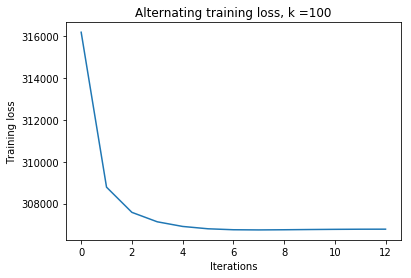

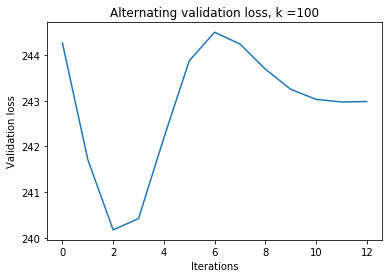

In [130]:

### YOUR PLOTTING CODE HERE ###
x_axis = np.arange(0,len(tr_l_a[1:]),1)
plt.plot(x_axis, tr_l_a[1:])
plt.xlabel('Iterations')
plt.ylabel('Training loss')
plt.title('Alternating training loss, k =100')
plt.show()
plt.plot(x_axis, val_l_a[1:])
plt.xlabel('Iterations')
plt.ylabel('Validation loss')
plt.title('Alternating validation loss, k =100')
plt.show()

b) (**Optional**): Try some different latent dimensions $k$ in the range [5, 100]. What do you observe (convergence time, final training/validation losses)?

In [131]:
Q_a_2, P_a_2, val_l_a_2, tr_l_a_2, conv_a_2 = latent_factor_alternating_optimization(M_shifted, nonzero_indices, 
                                                                           k=20, val_idx=val_idx,
                                                                           val_values=val_values_shifted, 
                                                                           reg_lambda=0.1, init='random',
                                                                           max_steps=100, patience=10)

Iteration 0, training loss: 7780823.397739252, validation loss: 5194.491086495006
Iteration 1, training loss: 341720.0377798526, validation loss: 263.18010099776967
Iteration 2, training loss: 330000.150236415, validation loss: 272.0434852646364
Iteration 3, training loss: 326826.5088377306, validation loss: 257.35523302321144
Iteration 4, training loss: 325617.58242618537, validation loss: 255.51158703679923
Iteration 5, training loss: 324874.8777126285, validation loss: 250.79936002886265
Iteration 6, training loss: 324646.73728782206, validation loss: 254.9967227089881
Iteration 7, training loss: 324492.81601368287, validation loss: 247.3469632871853
Iteration 8, training loss: 324741.79765385634, validation loss: 250.98185776077102
Iteration 9, training loss: 324748.01825519087, validation loss: 255.3592531907904
Iteration 10, training loss: 324939.2620168937, validation loss: 253.4319448424908
Iteration 11, training loss: 325223.0975850418, validation loss: 262.8467617143137
Itera

#### Plot the validation and training losses over (training) time

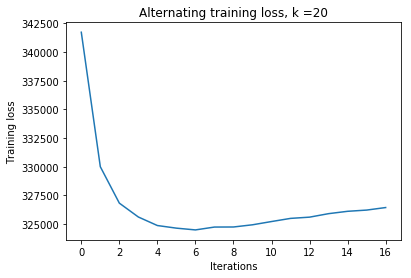

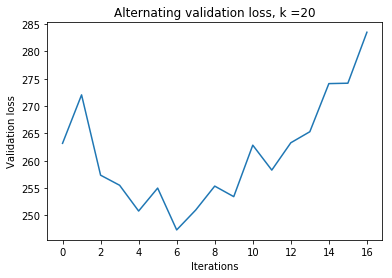

In [132]:

### YOUR PLOTTING CODE HERE ###
x_axis = np.arange(0,len(tr_l_a_2[1:]),1)
plt.plot(x_axis, tr_l_a_2[1:])
plt.xlabel('Iterations')
plt.ylabel('Training loss')
plt.title('Alternating training loss, k =20')
plt.show()
plt.plot(x_axis, val_l_a_2[1:])
plt.xlabel('Iterations')
plt.ylabel('Validation loss')
plt.title('Alternating validation loss, k =20')
plt.show()


## 4. Latent factorization using gradient descent

We now use gradient descent to factorize our ratings matrix. We will try both (mini-) batch and stochastic gradient descent. You can use the following equations for your implementation.

Recall that the objective function (loss) we wanted to optimize was:
$$
\mathcal{L} = \min_{P, Q} \sum_{(x, i) \in W} (r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2 + \lambda_1\sum_x{\left\lVert \mathbf{p}_x  \right\rVert}^2 + \lambda_2\sum_i {\left\lVert\mathbf{q}_i  \right\rVert}^2
$$

where $W$ is the set of $(x, i)$ pairs for which $r_{xi}$ is known (in this case our known play counts). Here we have also introduced two regularization terms to help us with overfitting where $\lambda_1$ and $\lambda_2$ are hyper-parameters that control the strength of the regularization.

Naturally optimizing with gradient descent involves computing the gradient of the loss function $\mathcal{L}$ w.r.t. to the parameters. To help you solve the task we provide the following:

$$
\frac{\partial ((r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2)}{\partial \mathbf{p}_x} = -2(r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)\mathbf{q}_i\;, ~~~
\frac{\partial ((r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2)}{\partial \mathbf{q}_i} = -2(r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)\mathbf{p}_x 
$$

$$
\frac{\partial(\lambda_1{\left\lVert \mathbf{p}_x \right\rVert}^2)}{\partial \mathbf{p}_x} = 2 \lambda_1 \mathbf{p_x} \;, ~~~
\frac{\partial(\lambda_2{\left\lVert \mathbf{q}_i \right\rVert}^2)}{\partial \mathbf{q}_i} = 2 \lambda_2 \mathbf{q_i}
$$

**Hint**: You have to carefully consider how to combine the given partial gradients depending
on which variants of gradient descent you are using.  
**Hint 2**: It may be useful to scale the updates to $P$ and $Q$ by $\frac{1}{batch\_size}$ (in the case of full-sweep updates, this would be $\frac{1}{n\_users}$ for $Q$ and $\frac{1}{n\_restaurants}$ for $P$).


For each of the gradients descent variants you try report and compare the following:
* How many iterations do you need for convergence.
* Plot the loss (y axis) for each iteration (x axis).


In [114]:
def latent_factor_gradient_descent(M, non_zero_idx, k, val_idx, val_values, 
                                   reg_lambda, learning_rate, batch_size=-1,
                                   max_steps=50000, init='random',
                                   log_every=1000, patience=20,
                                   eval_every=50):
    """
    Perform matrix factorization using gradient descent. Training is done via patience,
    i.e. we stop training after we observe no improvement on the validation loss for a certain
    amount of training steps. We then return the best values for Q and P oberved during training.
    
    Parameters
    ----------
    M                 : sp.spmatrix, shape [N, D]
                        The input matrix to be factorized.
                      
    non_zero_idx      : np.array, shape [nnz, 2]
                        The indices of the non-zero entries of the un-shifted matrix to be factorized. 
                        nnz refers to the number of non-zero entries. Note that this may be different
                        from the number of non-zero entries in the input matrix M, e.g. in the case
                        that all ratings by a user have the same value.
    
    k                 : int
                        The latent factor dimension.
    
    val_idx           : tuple, shape [2, n_validation]
                        Tuple of the validation set indices.
                        n_validation refers to the size of the validation set.
                      
    val_values        : np.array, shape [n_validation, ]
                        The values in the validation set.
                      
    reg_lambda        : float
                        The regularization strength.

    learning_rate     : float
                        Step size of the gradient descent updates.
                        
    batch_size        : int, optional, default: -1
                        (Mini-) batch size. -1 means we perform standard full-sweep gradient descent.
                        If the batch size is >0, use mini batches of this given size.
                        
    max_steps         : int, optional, default: 100
                        Maximum number of training steps. Note that we will stop early if we observe
                        no improvement on the validation error for a specified number of steps
                        (see "patience" for details).
                      
    init              : str in ['random', 'svd'], default 'random'
                        The initialization strategy for P and Q. See function initialize_Q_P for details.
    
    log_every         : int, optional, default: 1
                        Log the training status every X iterations.
                    
    patience          : int, optional, default: 10
                        Stop training after we observe no improvement of the validation loss for X evaluation
                        iterations (see eval_every for details). After we stop training, we restore the best 
                        observed values for Q and P (based on the validation loss) and return them.
                      
    eval_every        : int, optional, default: 1
                        Evaluate the training and validation loss every X steps. If we observe no improvement
                        of the validation error, we decrease our patience by 1, else we reset it to *patience*.
                        
    Returns
    -------
    best_Q            : np.array, shape [N, k]
                        Best value for Q (based on validation loss) observed during training
                      
    best_P            : np.array, shape [k, D]
                        Best value for P (based on validation loss) observed during training
                      
    validation_losses : list of floats
                        Validation loss for every evaluation iteration, can be used for plotting the validation
                        loss over time.
                        
    train_losses      : list of floats
                        Training loss for every evaluation iteration, can be used for plotting the training
                        loss over time.                     
    
    converged_after   : int
                        it - patience*eval_every, where it is the iteration in which patience hits 0,
                        or -1 if we hit max_steps before converging. 

    """
    temp_patience = patience
    best_val_loss = 1e6
    train_losses = []
    validation_losses = []
    Q, P = initialize_Q_P(M, k, init)
    non_zero_matrix = np.matrix((non_zero_idx[0], non_zero_idx[1])).T
    number_non_zeros = len(non_zero_idx[0])
    start = time.clock()
    for step in range(max_steps): 
        if batch_size != -1:
            non_zero_matrix_temp = non_zero_matrix[random.sample(range(0, number_non_zeros), batch_size)]
        else:
            non_zero_matrix_temp = non_zero_matrix

        for count in range(non_zero_matrix_temp.shape[0]):
            i = non_zero_matrix_temp[count,0]
            j = non_zero_matrix_temp[count,1]
            e_ij = M[i,j] - np.dot(Q[i,:],P[:,j])
            Q[i,:] = Q[i,:] + learning_rate * 2 * (e_ij * P[:,j] - reg_lambda * Q[i,:])
            P[:,j] = P[:,j] + learning_rate * 2 * (e_ij * Q[i,:] - reg_lambda * P[:,j])

        if step % eval_every == 0:
            # calculate the training loss
            train_loss = 0
            validation_loss = 0
            i = non_zero_matrix[:,0]
            j = non_zero_matrix[:,1]
            train_loss = np.sum(np.square(M[i,j] - np.matmul(Q,P)[i,j])) + reg_lambda * (np.sum(pow(Q[i, :], 2)) + np.sum(pow(P[:,j],2)))
            # calculate the validation loss
            i = val_idx[0]
            j = val_idx[1]
            validation_loss = np.sum(np.square(val_values - np.matmul(Q,P)[i,j])) + reg_lambda * (np.sum(pow(Q[i, :], 2)) + np.sum(pow(P[:,j],2)))
            if validation_loss < best_val_loss:
                best_val_loss = validation_loss
                best_Q = Q.copy()
                best_P = P.copy()
                validation_loss = np.sum(np.square(val_values - np.matmul(best_Q,best_P)[i,j]))
                print(validation_loss)
            if len(validation_losses) > 0:
                if validation_loss > best_val_loss or abs(validation_loss - best_val_loss) < 0.1:
                    temp_patience -= 1
                else:
                    temp_patience = patience
            train_losses.append(train_loss)
            validation_losses.append(validation_loss)
            if temp_patience == 0:
                converged_after = step - patience * eval_every
                end = time.clock()
                print('Converged after {} iterations, on average {}s per iteration'.format(converged_after, ((end-start)/step)))
                break
        if step % log_every == 0:
            print ('Iteration {}, training loss: {}, validation loss: {}'.format(step, train_loss, validation_loss))
            
    validation_loss = np.sum(np.square(val_values - np.matmul(best_Q,best_P)[i,j]))
    print(validation_loss)
    return best_Q, best_P, validation_losses, train_losses, converged_after

#### Train the latent factor model with alternating optimization.

a) Learn the optimal $P$ and $Q$ using standard gradient descent. That is, during each iteration you have to use all of the training examples and update $Q$ and $P$ for all users and songs at once. Try the algorithm with $k=30$, $\lambda=1$, and learning rate of 0.1. Initialize $Q$ and $P$ with SVD.  

In [115]:
Q_g_sweep, P_g_sweep, val_l_g_sweep, tr_l_g_sweep, conv_g_sweep =  latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                                   k=30, val_idx=val_idx,
                                                                                                   val_values=val_values_shifted, 
                                                                                                   reg_lambda=1, learning_rate=1e-1,
                                                                                                   init='svd', batch_size=-1,
                                                                                                   max_steps=10000, log_every=1, 
                                                                                                   eval_every=1, patience=3)



240.50077931587197
Iteration 0, training loss: 349578.23343736684, validation loss: 240.50077931587197
240.49022387728598
Iteration 1, training loss: 337264.7829468076, validation loss: 240.49022387728598
240.4904250651322
Iteration 2, training loss: 337200.91561263474, validation loss: 240.4904250651322
240.49045027220563
Converged after 0 iterations, on average 19.09422866666652s per iteration
240.49045027220563


In [33]:
Q_g_sweep, P_g_sweep, val_l_g_sweep, tr_l_g_sweep, conv_g_sweep =  latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                                   k=30, val_idx=val_idx,
                                                                                                   val_values=val_values_shifted, 
                                                                                                   reg_lambda=1, learning_rate=1e-1,
                                                                                                   init='svd', batch_size=-1,
                                                                                                   max_steps=10000, log_every=10, 
                                                                                                   eval_every=10, patience=10)


Iteration 0, training loss: 349578.2334373663, validation loss: 249.0824600336538
Iteration 10, training loss: 337387.7806997647, validation loss: 240.4936273470866
Iteration 20, training loss: 337381.9348144661, validation loss: 240.49354389879343
Iteration 30, training loss: 337378.5368741187, validation loss: 240.4935054834346
Iteration 40, training loss: 337377.22356218845, validation loss: 240.4934892109841
Iteration 50, training loss: 337376.6807145653, validation loss: 240.4934819934496
Iteration 60, training loss: 337376.4449793334, validation loss: 240.49347869739847
Iteration 70, training loss: 337376.338595263, validation loss: 240.49347714381096
Iteration 80, training loss: 337376.2887480849, validation loss: 240.4934763823461
Iteration 90, training loss: 337376.2642253026, validation loss: 240.493475988051
Iteration 100, training loss: 337376.2512272088, validation loss: 240.4934757668622
Converged after 10 iterations, on average 13.51512520909091s per iteration


#### Plot the validation and training losses over (training) time

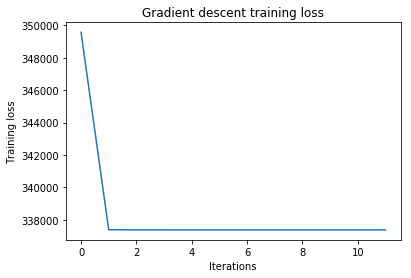

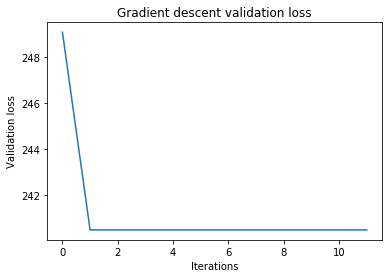

In [38]:

### YOUR PLOTTING CODE HERE ###
x_axis = np.arange(0,len(tr_l_g_sweep),1)
plt.plot(x_axis, tr_l_g_sweep)
plt.xlabel('Iterations')
plt.ylabel('Training loss')
plt.title('Gradient descent training loss')
plt.show()
plt.plot(x_axis, val_l_g_sweep)
plt.xlabel('Iterations')
plt.ylabel('Validation loss')
plt.title('Gradient descent validation loss')
plt.show()


b) Learn the optimal $P$ and $Q$ using the original stochastic gradient descent (mini-batches of size 1). That is, during each iteration you sample a single random training example $r_{xi}$ and update only the respective affected parameters $\mathbf{p_x}$ and $\mathbf{q}_i$. Set the learning rate to 0.01 and keep the other parameters as in a).

In [47]:
Q_g_st, P_g_st, val_l_g_st, tr_l_g_st, conv_g_st = latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                   k=30, val_idx=val_idx,
                                                                                   val_values=val_values_shifted, 
                                                                                   reg_lambda=1, learning_rate=0.1,
                                                                                   init='svd', batch_size=1,
                                                                                   max_steps=200000, log_every=500, 
                                                                                   eval_every=50)

Iteration 0, training loss: 2829151.014325686, validation loss: 2482.78418290326
Iteration 500, training loss: 2305371.634295337, validation loss: 1919.1621933653835
Iteration 1000, training loss: 1951873.9536442175, validation loss: 1535.397249813742
Iteration 1500, training loss: 1718469.9451710233, validation loss: 1355.0022297521812
Iteration 2000, training loss: 1533759.3581891262, validation loss: 1173.8257731680926
Iteration 2500, training loss: 1432391.1984599838, validation loss: 1104.3749250083672
Iteration 3000, training loss: 1355053.466052285, validation loss: 1022.7985517205182
Iteration 3500, training loss: 1284675.5427534042, validation loss: 948.0464327136957
Iteration 4000, training loss: 1210993.312261607, validation loss: 866.0394470355404
Iteration 4500, training loss: 1156759.428326902, validation loss: 799.6657944795113
Iteration 5000, training loss: 1115843.1421100239, validation loss: 779.2535734708989
Iteration 5500, training loss: 1081734.0110853761, validati

#### Plot the validation and training losses over (training) time

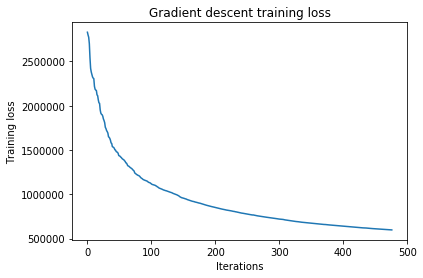

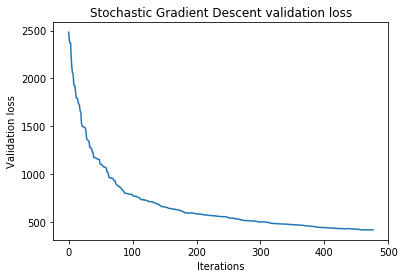

In [48]:

### YOUR PLOTTING CODE HERE ###
x_axis = np.arange(0,len(tr_l_g_st),1)
plt.plot(x_axis, tr_l_g_st)
plt.xlabel('Iterations')
plt.ylabel('Training loss')
plt.title('Gradient descent training loss')
plt.show()
plt.plot(x_axis, val_l_g_st)
plt.xlabel('Iterations')
plt.ylabel('Validation loss')
plt.title('Stochastic Gradient Descent validation loss')
plt.show()

c) (**Optional**) Learn the optimal $P$ and $Q$ similarly to b) this time using larger mini-batches of size $S$, e.g. 32.

In [30]:
Q_g_mb, P_g_mb, val_l_g_mb, tr_l_g_mb, conv_g_mb = latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                   k=30, val_idx=val_idx,
                                                                                   val_values=val_values_shifted, 
                                                                                   reg_lambda=1, learning_rate=1e-1,
                                                                                   init='svd', batch_size=32,
                                                                                   max_steps=10000, log_every=100, 
                                                                                   eval_every=50)

Iteration 0, training loss: 2827276.728346734, validation loss: 2483.2176258583786
Iteration 100, training loss: 1415977.608728465, validation loss: 1119.430111300056
Iteration 200, training loss: 1032887.3875049842, validation loss: 749.0322647743246
Iteration 300, training loss: 861608.3225270393, validation loss: 605.6955414101676
Iteration 400, training loss: 763664.6106751349, validation loss: 540.1946233323221
Iteration 500, training loss: 696769.1681086554, validation loss: 490.7142762346009
Iteration 600, training loss: 645993.4359717123, validation loss: 451.4669581489528
Iteration 700, training loss: 605300.7399028396, validation loss: 409.079917575578
Iteration 800, training loss: 572108.9645208666, validation loss: 392.9897140269886
Iteration 900, training loss: 548203.4562704808, validation loss: 376.9763950719186
Iteration 1000, training loss: 527996.5686842324, validation loss: 366.5940126135967
Iteration 1100, training loss: 509112.7647124338, validation loss: 355.30394

#### Plot the validation and training losses over (training) time

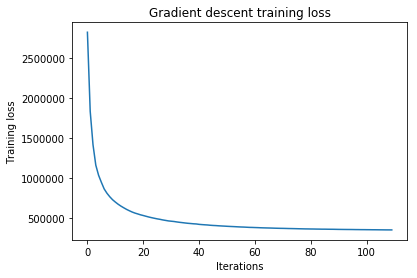

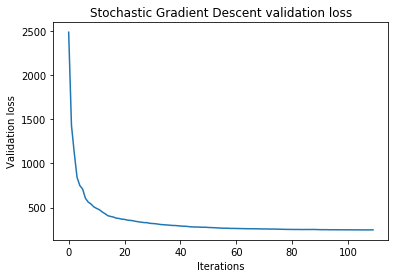

In [34]:

### YOUR PLOTTING CODE HERE ###
x_axis = np.arange(0,len(tr_l_g_mb),1)
plt.plot(x_axis, tr_l_g_mb)
plt.xlabel('Iterations')
plt.ylabel('Training loss')
plt.title('Gradient descent training loss')
plt.show()
plt.plot(x_axis, val_l_g_mb)
plt.xlabel('Iterations')
plt.ylabel('Validation loss')
plt.title('Stochastic Gradient Descent validation loss')
plt.show()


### 4.5 Hyperparameter search

Machine learning models are often heavily dependent on the hyperparameter settings, e.g. the learning rate. Here, we will try a simple random search to find good values of the latent factor dimension $k$, the batch size, learning rate, and regularization.  

### Tasks:

Perform a hyperparameter search to find good values for the batch size, lambda, learning rate, and latent dimension. 

* For the batch size, evaluate all values in [1, 32, 512, -1] (-1 corresponds to full-sweep gradient descent).
* For $\lambda$, randomly sample three values in the interval [0, 1).
* For the learning rate, evaluate all values in [1, 0.1, 0.01].
* For the latent dimension, uniformly sample three values in the interval [5,30].

Perform an exhaustive search among all combinations of these values;

**Hint**: This may take a while to compute. **You don't have to wait for all the models to train** -- simply use "dummy" code instead of actual model training (or let it train, e.g., for only one iteration) if you don't want to wait. Note that the signature of this dummy code has to match the function 'latent_factor_gradient_descent' so that we could simply plug in the actual function.



In [83]:
def parameter_search(M_train, val_idx, val_values):
    """
    Hyperparameter search using random search.
    
    Parameters
    ----------
    
    M_train     : sp.spmatrix, shape [N, D]
                  Input sparse matrix where the user means have not
                  been subtracted yet. 
                  
    val_idx     : tuple, shape [2, n_validation]
                  The indices used for validation, where n_validation
                  is the size of the validation set.
                  
    val_values  : np.array, shape [n_validation, ]
                  Validation set values, where n_validation is the
                  size of the validation set.

    Returns
    -------
    best_conf   : tuple, (batch_size, lambda, learning_rate, latent_dimension)
                  The best-performing hyperparameters.
                  

    """
    nonzero_indices = M_train.nonzero()
    # Remove user means.
    M_shifted, means = shift_user_mean(M_train)
    batches = [1, 32, 512, -1]
    regulaizer = np.random.random_sample(3).tolist()
    learning_rate = [0.01, 0.1, 1]
    ks = np.random.randint(5,30,3).tolist()
    best_val_loss_so_far = 1e6
    for batch in batches:
        for lamda in regulaizer:
            for lr in learning_rate:
                for k in ks:
                    print('Training with configuration: batch: {}, lambda: {}, lr: {}, k: {}'.format(batch, lamda, lr,k))
                    best_Q, best_P, validation_losses, train_losses, converged_after = latent_factor_gradient_descent(M_shifted, 
                                                                                                                      nonzero_indices,
                                                                                                                      k=k, 
                                                                                                                      val_idx=val_idx,
                                                                                                                      val_values=val_values,
                                                                                                                      reg_lambda=lamda, 
                                                                                                                      learning_rate=lr,
                                                                                                                      batch_size=batch,
                                                                                                                      log_every=500)
                    
                    current_best_val_loss = min(validation_losses)
                    print('Done. Best validation loss {}'.format(current_best_val_loss))
                    if current_best_val_loss < best_val_loss_so_far:
                        best_val_loss_so_far = current_best_val_loss
                        best_conf = (batch, lamda, lr, k)
                        print('New best configuration: batch: {}, lambda: {}, lr: {}, k: {}'.format(batch, lamda, lr,k))
                        return best_conf # we return after one combination of hyper paramters
                        # should be removed
                        
                    
    
    ### YOUR CODE HERE ###
        
    print("Best configuration is {}").format(best_conf)
    return best_conf
    

In [84]:
best_configuration = parameter_search(M_train, val_idx, val_values)

Training with configuration: batch: 1, lambda: 0.5128774665768658, lr: 0.01, k: 26
Iteration 0, training loss: 15406251.669941604, validation loss: 3698.9612476665006
Iteration 500, training loss: 13951771.944088561, validation loss: 3276.3935536682343
Iteration 1000, training loss: 12836539.971229248, validation loss: 2998.0171321886755
Iteration 1500, training loss: 11876326.710761452, validation loss: 2835.5667326372977
Iteration 2000, training loss: 11115225.859797541, validation loss: 2768.412288416437
Iteration 2500, training loss: 10444277.729501316, validation loss: 2698.541367584944
Iteration 3000, training loss: 9872517.223938894, validation loss: 2671.978015555188
Iteration 3500, training loss: 9338426.316691622, validation loss: 2611.054411249019
Iteration 4000, training loss: 8887299.813731836, validation loss: 2550.6807542574234
Iteration 4500, training loss: 8456326.93918916, validation loss: 2510.4182373551553
Iteration 5000, training loss: 8086194.122743678, validation

#### Output the best hyperparameter optimization

In [ ]:

### YOUR CODE HERE ###


## 5. Comparison of gradient descent and alternating optimization

After training the latent factor model with both alternating optimization and gradient descent, we now compare their results on the training, validation, and test set.

### Tasks

* Compare the root mean square errors (RMSE) for the training, validation, and test sets different settings of $k$ for both alternating optimization and gradient descent. What do you observe?
* Compare the test RMSE for the alternating optimization model and the gradient descent model. Which performs better?
* Plot the predicted ratings

**Hint**: The output values and plots below are the ones we got when testing this sheet. Yours may be different, but if your validation or test RMSE values are larger than 1.5 or 2, it is likely that you have a bug in your implementation.

In [133]:
i = nonzero_indices[0]
j = nonzero_indices[1]
rmse_train = np.sqrt(np.sum(np.square(M_shifted[i,j] - np.matmul(Q_a_1, P_a_1)[i,j])) / len(i))
i = val_idx[0]
j = val_idx[1]
rmse_val = np.sqrt(np.sum(np.square(val_values_shifted - np.matmul(Q_a_1, P_a_1)[i,j])) / len(i))
i = test_idx[0]
j = test_idx[1]
rmse_test = np.sqrt(np.sum(np.square(test_values_shifted - np.matmul(Q_a_1, P_a_1)[i,j])) / len(i))
print('Training RMSE of best alternating optimization model: {}'.format(rmse_train))
print('Validation RMSE of best alternating optimization model: {}'.format(rmse_val))
print('Test RMSE of best alternating optimization model: {}'.format(rmse_test))

NameError: name 'Q_a_1' is not defined

In [123]:
i = nonzero_indices[0]
j = nonzero_indices[1]
rmse_train = np.sqrt(np.sum(np.square(M_shifted[i,j] - np.matmul(Q_g_sweep, P_g_sweep)[i,j])) / len(i))
i = val_idx[0]
j = val_idx[1]
rmse_val = np.sqrt(np.sum(np.square(val_values_shifted - np.matmul(Q_g_sweep, P_g_sweep)[i,j])) / len(i))
i = test_idx[0]
j = test_idx[1]
rmse_test = np.sqrt(np.sum(np.square(test_values_shifted - np.matmul(Q_g_sweep, P_g_sweep)[i,j])) / len(i))
print('Training RMSE of best gradient descent model: {}'.format(rmse_train))
print('Validation RMSE of best gradient descent model: {}'.format(rmse_val))
print('Test RMSE of best gradient descent model: {}'.format(rmse_test))

Training RMSE of best gradient descent model: 1.0876420343952424
Validation RMSE of best gradient descent model: 1.0965638382515759
Test RMSE of best gradient descent model: 1.110586965699066


#### Plots: Prediction vs. ground truth ratings

In [ ]:

### YOUR PLOTTING CODE HERE ###


In [ ]:

### YOUR PLOTTING CODE HERE ###


In [ ]:

### YOUR PLOTTING CODE HERE ###


In [ ]:

### YOUR PLOTTING CODE HERE ###
